In [2]:
#Load necessary packages

# data management
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scaler
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# addition to models
from sklearn.calibration import CalibratedClassifierCV

# data splitting
from sklearn.model_selection import train_test_split

# scoring
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# time execution
import time

ncores = 32

In [2]:
adata  = sc.read("analysis/integration/anndata_annot.h5ad")

In [3]:
adata.shape

(21255, 33262)

In [4]:
adata.var_names.values.shape

(33262,)

In [5]:
adata.obs_names.values.shape

(21255,)

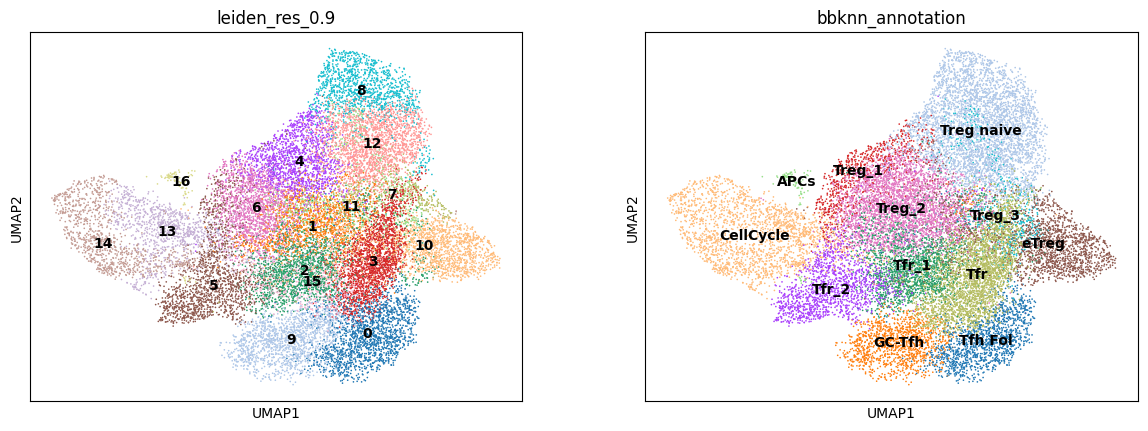

In [6]:
sc.pl.umap(adata, color=["leiden_res_0.9","bbknn_annotation"], 
           legend_loc="on data", ncols=2)

In [9]:
meta_model = adata.obs.loc[adata.obs["leiden_res_0.9"].isin(['0','3','9','10','15']), :].copy()
meta_model["leiden_res_0.9"].unique()

['0', '10', '3', '15', '9']
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']

In [10]:
meta_model["leiden_res_0.9"] = meta_model["leiden_res_0.9"].cat.remove_unused_categories()
meta_model["leiden_res_0.9"].unique()

['0', '10', '3', '15', '9']
Categories (5, object): ['0', '3', '9', '10', '15']

In [11]:
meta_model["cell_type"] = meta_model["cell_type"].cat.remove_unused_categories()
meta_model["cell_type"].unique()

['Tfh', 'Treg', 'Tfr']
Categories (3, object): ['Tfh', 'Tfr', 'Treg']

In [12]:
meta_model.shape

(7389, 35)

In [7]:
# variable for classification
meta_model["annot_classifier"] = meta_model["leiden_res_0.9"].map(
    {
        "0": "Tfh",
        "3": "Tfr",
        "9": "Tfh",
        "10": "Treg",
        "15": "Tfr"
    }
)

In [8]:
meta_model["annot_classifier"].unique()

array(['Tfh', 'Treg', nan, 'Tfr'], dtype=object)

In [13]:
# possible variable for startification
meta_model["cluster_annot"] = meta_model["leiden_res_0.9"].map(
    {
        "0": "Tfh_Fol",
        "3": "Tfr_Fol",
        "9": "GC_Tfh",
        "10": "Treg",
        "15": "GC_Tfr"
    }
)

In [14]:
meta_model["annot_classifier"].unique()

array(['Tfh', 'Treg', 'Tfr'], dtype=object)

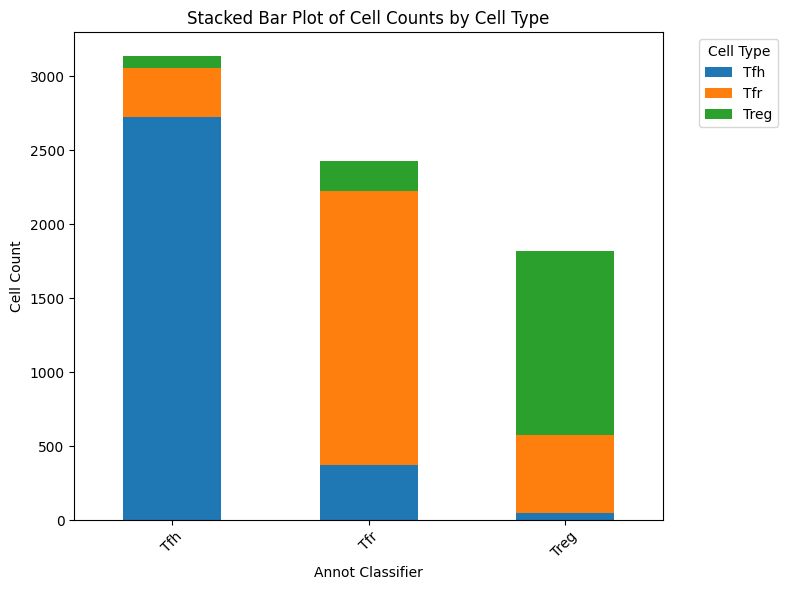

In [15]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_model.groupby(['annot_classifier', 'cell_type']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Annot Classifier')
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

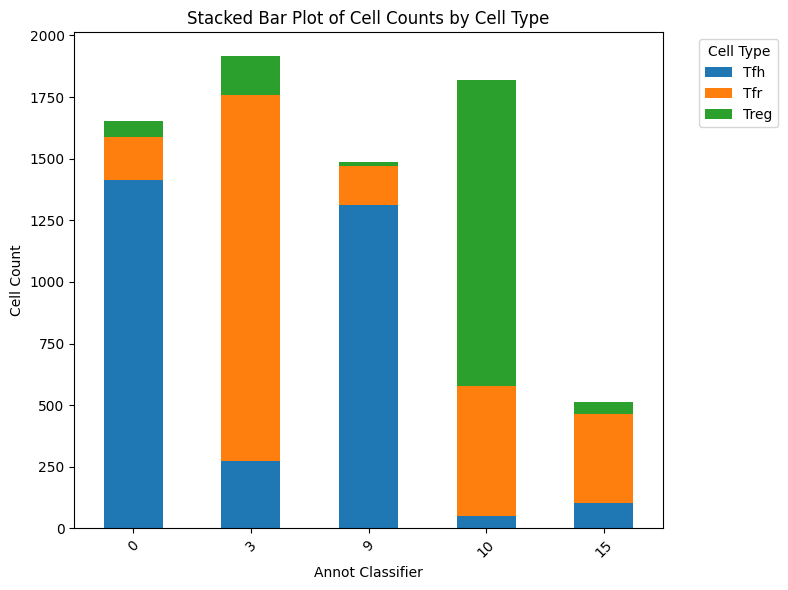

In [16]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_model.groupby(['leiden_res_0.9', 'cell_type']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Annot Classifier')
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# only use cells for which the cluster annotation matches the sorting

In [17]:
meta_model = meta_model[meta_model['annot_classifier'] == meta_model['cell_type']]

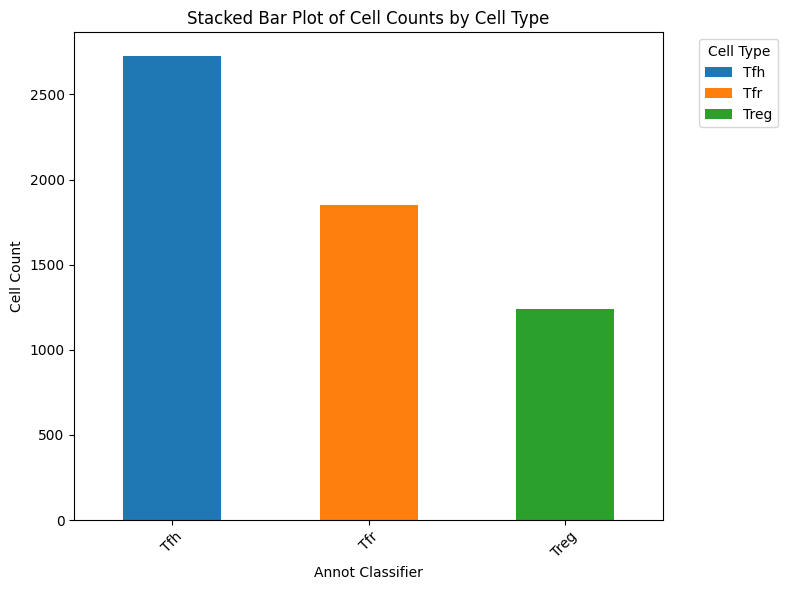

In [18]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_model.groupby(['annot_classifier', 'cell_type']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Annot Classifier')
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
meta_model.shape

(5821, 36)

In [ ]:
###

In [22]:
exp = adata.layers["data"].copy().transpose()
exp = exp[:, (adata.obs["leiden_res_0.9"].isin(['0', '3', '9', '10', '15'])) & 
             (adata.obs["annot_classifier"].astype(str) == adata.obs["cell_type"].astype(str))] # for selecting only when cluster annot matches cell_type
exp

<33262x5821 sparse matrix of type '<class 'numpy.float32'>'
	with 11213530 stored elements in Compressed Sparse Column format>

In [20]:
# when not subsetting for cell_type matching
exp = adata.layers["data"].copy().transpose()
exp = exp[:, adata.obs["leiden_res_0.9"].isin(['0','3','9','10','15'])]
exp

<33262x7389 sparse matrix of type '<class 'numpy.float32'>'
	with 14276567 stored elements in Compressed Sparse Column format>

In [23]:
# make genes uniform
g_use = np.asarray(exp.sum(axis = 1)>0)[:,0]
exp_model = exp[g_use,:].transpose()
exp_model

<5821x17441 sparse matrix of type '<class 'numpy.float32'>'
	with 11213530 stored elements in Compressed Sparse Row format>

In [ ]:
# Classifier

In [ ]:
#first version random state 42
#second version random state 42

In [24]:
# split data into train and test fractions
X_train, X_test, y_train, y_test = train_test_split(exp_model, meta_model["annot_classifier"], test_size=0.2, 
                                                    random_state=42, stratify = meta_model["annot_classifier"].values)

In [25]:
X_train.shape

(4656, 17441)

In [26]:
meta_train = meta_model.loc[y_train.index.values, :].copy()

In [27]:
meta_train.shape

(4656, 36)

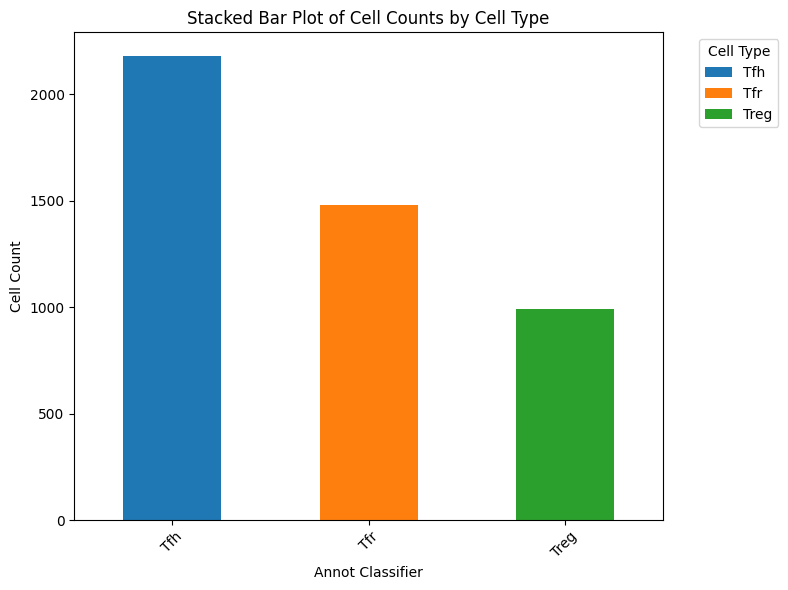

In [28]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_train.groupby(['annot_classifier', 'cell_type']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Annot Classifier')
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

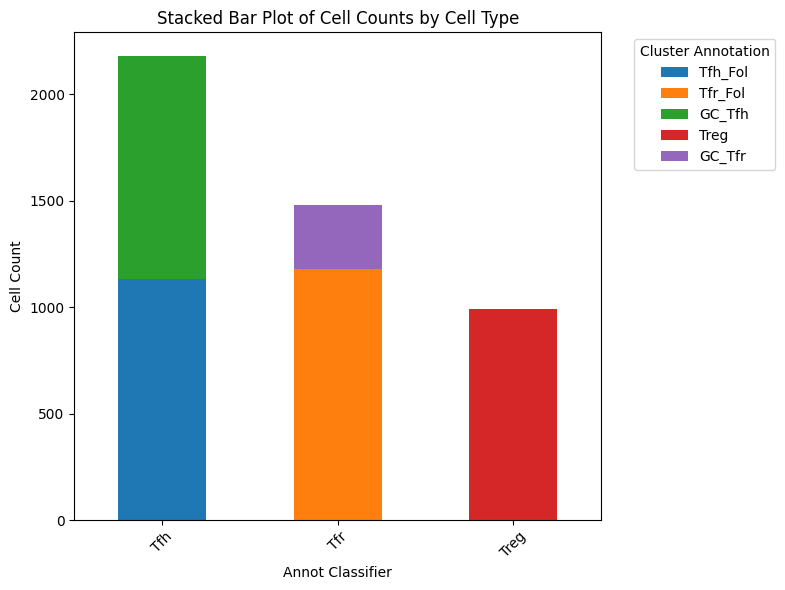

In [29]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_train.groupby(['annot_classifier', 'cluster_annot']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Annot Classifier')
plt.xticks(rotation=45)
plt.legend(title='Cluster Annotation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [30]:
y_test.shape

(1165,)

In [31]:
meta_test = meta_model.loc[y_test.index.values, :].copy()

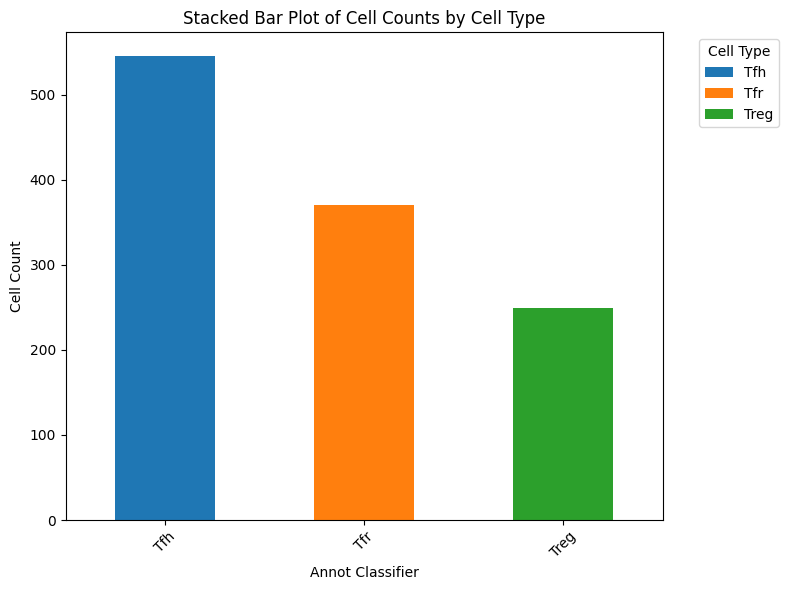

In [32]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_test.groupby(['annot_classifier', 'cell_type']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Annot Classifier')
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

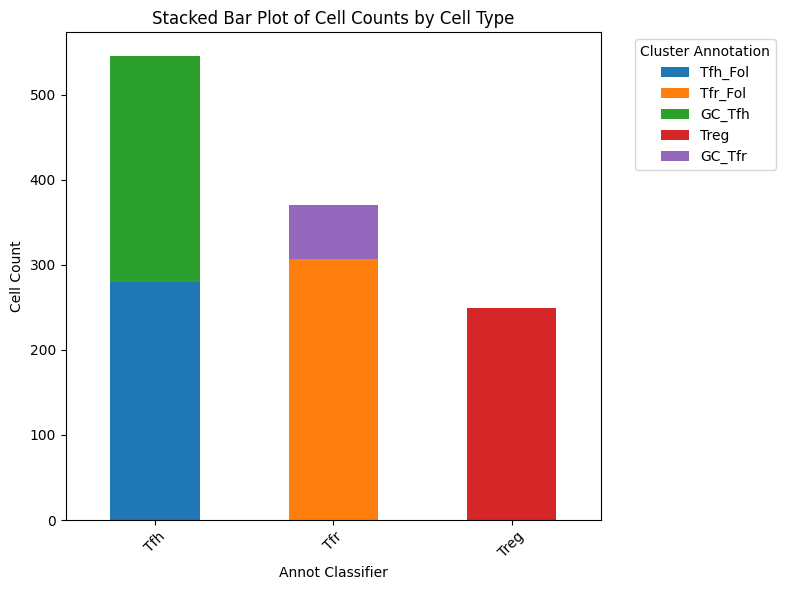

In [33]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_test.groupby(['annot_classifier', 'cluster_annot']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Annot Classifier')
plt.xticks(rotation=45)
plt.legend(title='Cluster Annotation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [203]:
scaler = StandardScaler(with_mean = False)
scaler.fit(X_train)

# scale
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# save scaler
with open("analysis/model_classifier/new/v2_scaler.pkl", "wb") as f:
    pickle.dump(scaler, file=f)

In [34]:
# Load the pre-fitted scaler
with open("analysis/model_classifier/new/v2_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Transform your data using the loaded scaler
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [204]:
# create classifiers
rfc = RandomForestClassifier(random_state = 1, n_estimators = 1000, n_jobs = ncores)
lr = LogisticRegression(random_state = 1, max_iter = 250, n_jobs = ncores)

In [205]:
# train classifiers
start_time = time.time()
cal_rfc = CalibratedClassifierCV(rfc, method="sigmoid", cv=5, n_jobs = ncores)
cal_rfc.fit(X_train_sc, y_train)
print("RF 1vRest: %s seconds" % (round(time.time() - start_time, 2)))
with open("analysis/model_classifier/new/v2_cal_rfc_model.pkl", "wb") as f:
    pickle.dump(cal_rfc, file=f)
    
start_time = time.time()
cal_lr = CalibratedClassifierCV(lr, method="isotonic", cv=5, n_jobs = ncores)
cal_lr.fit(X_train_sc, y_train)
print("LR 1vRest: %s seconds" % (round(time.time() - start_time, 2)))
with open("analysis/model_classifier/new/v2_cal_lr_model.pkl", "wb") as f:
    pickle.dump(cal_lr, file=f)

RF 1vRest: 366.32 seconds
LR 1vRest: 7.71 seconds


In [206]:
# use models to predict test data
start_time = time.time()
pred_rfc = cal_rfc.predict(X_test_sc)
print("RF 1vRest: %s seconds" % (round(time.time() - start_time, 2)))

start_time = time.time()
pred_lr = cal_lr.predict(X_test_sc)
print("LR 1vRest: %s seconds" % (round(time.time() - start_time, 2)))

RF 1vRest: 12.04 seconds
LR 1vRest: 0.07 seconds


In [35]:
with open("analysis/model_classifier/new/v2_cal_rfc_model.pkl", "rb") as f:
    cal_rfc = pickle.load(f)

start_time = time.time()
pred_rfc = cal_rfc.predict(X_test_sc)
print("LR 1vRest prediction time: %s seconds" % (round(time.time() - start_time, 2)))

with open("analysis/model_classifier/new/v2_cal_lr_model.pkl", "rb") as f:
    cal_lr = pickle.load(f)

start_time = time.time()
pred_lr = cal_lr.predict(X_test_sc)
print("LR 1vRest prediction time: %s seconds" % (round(time.time() - start_time, 2)))

LR 1vRest prediction time: 10.2 seconds
LR 1vRest prediction time: 0.08 seconds


In [36]:
# get F1 score for predictions
f1_rfc = f1_score(y_test, pred_rfc, average = "macro")
print(f1_rfc)

f1_lr = f1_score(y_test, pred_lr, average = "macro")
print(f1_lr)

0.9584928745160911
0.9543338100799232


In [ ]:
#v1_f1_rfc = 0.873527945326594
#v1_f1_lr = 0.891231055850314
#v2_f1_rfc = 0.9584928745160911
#v2_f1_lr = 0.9543338100799232

In [208]:
all_rfc = precision_recall_fscore_support(y_test, pred_rfc, zero_division = 0)
with open("analysis/model_classifier/new/v2_PRFSup_rfc.pkl", "wb") as f:
    pickle.dump(all_rfc, file=f)

all_lr = precision_recall_fscore_support(y_test, pred_lr, zero_division = 0)
with open("analysis/model_classifier/new/v2_PRFSup_lr.pkl", "wb") as f:
    pickle.dump(all_lr, file=f)

In [49]:
with open('analysis/model_classifier/new/v2_PRFSup_lr.pkl', 'rb') as f:
    all_lr = pickle.load(f)
    
all_lr

(array([0.97297297, 0.93650794, 0.96982759]),
 array([0.98901099, 0.95675676, 0.90361446]),
 array([0.98092643, 0.94652406, 0.93555094]),
 array([546, 370, 249]))

In [51]:
with open('analysis/model_classifier/new/v2_PRFSup_rfc.pkl', 'rb') as f:
    all_rfc = pickle.load(f)
    
all_rfc

(array([0.97644928, 0.94101877, 0.96666667]),
 array([0.98717949, 0.94864865, 0.93172691]),
 array([0.98178506, 0.9448183 , 0.94887526]),
 array([546, 370, 249]))

In [209]:
# get probabilities
start_time = time.time()
proba_rfc = cal_rfc.predict_proba(X_test_sc)
print("RF 1vRest: %s seconds" % (round(time.time() - start_time, 2)))
probs_df = pd.DataFrame(proba_rfc, index=y_test.index.values, columns=cal_rfc.classes_)
pd.concat([pd.DataFrame({"y_test": y_test, "pred_rfc": pred_rfc}), probs_df], axis = 1).to_csv("analysis/model_classifier/new/v2_preds_rfc.csv")

start_time = time.time()
proba_lr = cal_lr.predict_proba(X_test_sc)
print("LR 1vRest: %s seconds" % (round(time.time() - start_time, 2)))
probs_df = pd.DataFrame(proba_lr, index=y_test.index.values, columns=cal_lr.classes_)
pd.concat([pd.DataFrame({"y_test": y_test, "pred_lr": pred_lr}), probs_df], axis = 1).to_csv("analysis/model_classifier/new/v2_preds_lr.csv")

RF 1vRest: 12.06 seconds
LR 1vRest: 0.07 seconds


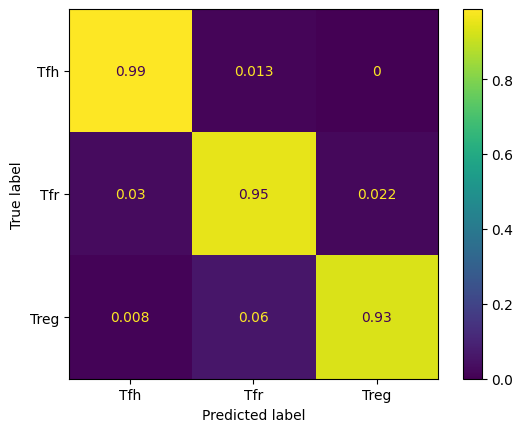

In [53]:
cm = confusion_matrix(y_test, pred_rfc, labels=cal_lr.classes_, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=cal_lr.classes_)
disp.plot()
plt.show()

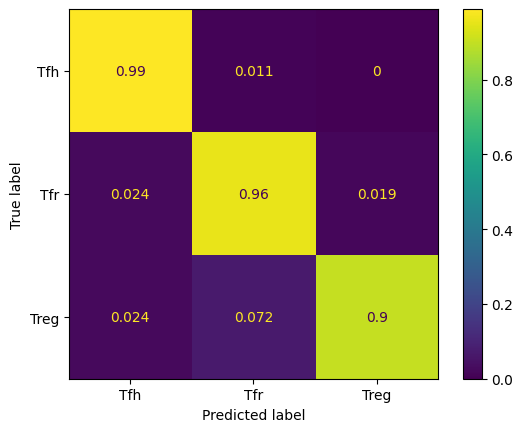

In [54]:
cm = confusion_matrix(y_test, pred_lr, labels=cal_lr.classes_, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=cal_lr.classes_)
disp.plot()
plt.show()

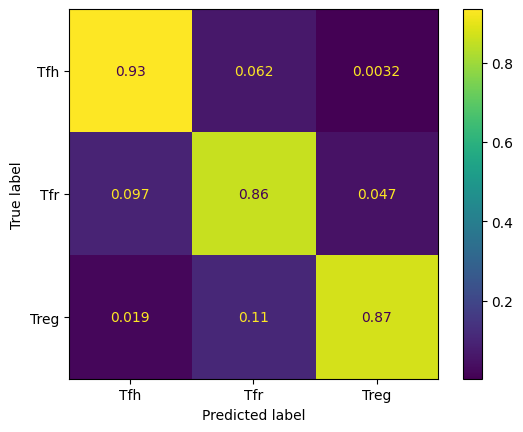

In [160]:
#old version
cm = confusion_matrix(y_test, pred_lr, labels=cal_lr.classes_, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=cal_lr.classes_)
disp.plot()
plt.show()

In [37]:
y_test_cluster = meta_test.loc[y_test.index, 'cluster_annot']

In [38]:
y_test_sort = meta_test.loc[y_test.index, 'cell_type']

In [39]:
pd.crosstab(y_test, y_test_sort, normalize="index")

cell_type,Tfh,Tfr,Treg
annot_classifier,,,
Tfh,1.0,0.0,0.0
Tfr,0.0,1.0,0.0
Treg,0.0,0.0,1.0


In [40]:
pd.crosstab(y_test, pred_lr, normalize="index")

col_0,Tfh,Tfr,Treg
annot_classifier,,,
Tfh,0.989011,0.010989,0.000000
Tfr,0.024324,0.956757,0.018919
Treg,0.024096,0.072289,0.903614


In [41]:
pd.crosstab(y_test_sort, pred_lr, normalize="index")

col_0,Tfh,Tfr,Treg
cell_type,,,
Tfh,0.989011,0.010989,0.000000
Tfr,0.024324,0.956757,0.018919
Treg,0.024096,0.072289,0.903614


In [42]:
pd.crosstab(y_test_cluster, pred_lr, normalize="index")

col_0,Tfh,Tfr,Treg
cluster_annot,,,
Tfh_Fol,0.985714,0.014286,0.000000
Tfr_Fol,0.026059,0.954397,0.019544
GC_Tfh,0.992481,0.007519,0.000000
Treg,0.024096,0.072289,0.903614
GC_Tfr,0.015873,0.968254,0.015873


In [43]:
pd.crosstab(y_test_cluster, pred_lr)

col_0,Tfh,Tfr,Treg
cluster_annot,,,
Tfh_Fol,276,4,0
Tfr_Fol,8,293,6
GC_Tfh,264,2,0
Treg,6,18,225
GC_Tfr,1,61,1


In [47]:
low_feat_thr = 500
high_feat_thr = 3000

conditions = [
    meta_test['nFeature_RNA'] < low_feat_thr,
    meta_test['nFeature_RNA'] > high_feat_thr
]

# Create and assign the categorical column
meta_test['coverage_cat'] = pd.Categorical(
    np.select(conditions, ['low_coverage', 'high_coverage'], default='mid_coverage'),
    categories=['low_coverage', 'mid_coverage', 'high_coverage'],  # ordered manually
    ordered=True  # optional: if you want to reflect order
)

In [48]:
meta_test

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,experiment,day,cell_type,S.Score,G2M.Score,...,leiden_res_0.5,leiden_res_0.6,leiden_res_0.7,leiden_res_0.8,leiden_res_0.9,leiden_res_1.0,bbknn_annotation,annot_classifier,cluster_annot,coverage_cat
D104T13_GTCGGGTTCACCAGGC-1,D104T13,944,598,2.754237,22.775424,GFP,11,Treg,-0.041708,-0.051473,...,0,5,2,7,10,13,eTreg,Treg,Treg,mid_coverage
D104T11_GGACAAGTCAGTCAGT-1,D104T11,13341,3348,2.158759,29.165730,GFP,6,Tfh,-0.068751,-0.028112,...,0,1,0,9,9,1,GC-Tfh,Tfh,GC_Tfh,high_coverage
D104T11_CGTGTCTTCTATCCTA-1,D104T11,4213,1606,2.895799,31.592689,GFP,6,Tfh,-0.013504,0.007264,...,0,0,1,0,0,0,Tfh Fol,Tfh,Tfh_Fol,mid_coverage
hCD2_d11_Tfr_TGCTTGCGTTATTCTC-1,hCD2_d11_Tfr,11122,2834,5.196907,23.278187,hCD2,11,Tfr,-0.109785,-0.063382,...,0,7,2,7,3,2,Tfr,Tfr,Tfr_Fol,mid_coverage
D104T14_ACCTTTATCCTCCTAG-1,D104T14,1109,644,4.328224,26.961226,GFP,11,Tfh,0.011617,-0.089748,...,0,0,0,9,9,0,Tfh Fol,Tfh,GC_Tfh,mid_coverage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D104T11_CGAATGTGTAGGCTGA-1,D104T11,9389,2802,3.046118,27.500266,GFP,6,Tfh,-0.042011,-0.124787,...,1,1,0,9,9,1,GC-Tfh,Tfh,GC_Tfh,mid_coverage
hCD2_d6_Tfr_AAACCCAGTATCGAAA-1,hCD2_d6_Tfr,3022,1492,4.731966,15.519523,hCD2,6,Tfr,-0.065125,0.038340,...,0,7,2,7,3,13,Tfr,Tfr,Tfr_Fol,mid_coverage
hCD2_d6_Tfr_TGGCGTGCAAATGAAC-1,hCD2_d6_Tfr,10359,3130,3.185636,26.402162,hCD2,6,Tfr,-0.086961,0.022603,...,0,7,2,7,3,13,Tfr,Tfr,Tfr_Fol,high_coverage
D104T14_GGCCGATCATTCTCAT-1,D104T14,2942,1475,2.753229,21.312033,GFP,11,Tfh,-0.048977,-0.047656,...,1,1,0,9,9,1,GC-Tfh,Tfh,GC_Tfh,mid_coverage


In [49]:
y_test_cover = meta_test.loc[y_test.index, 'coverage_cat']

In [50]:
pd.crosstab([y_test, y_test_cover], pred_lr, normalize="index")

col_0                                Tfh       Tfr      Treg
annot_classifier coverage_cat                               
Tfh              low_coverage   0.885714  0.114286  0.000000
                 mid_coverage   0.995604  0.004396  0.000000
                 high_coverage  1.000000  0.000000  0.000000
Tfr              low_coverage   0.102041  0.857143  0.040816
                 mid_coverage   0.018779  0.957746  0.023474
                 high_coverage  0.000000  1.000000  0.000000
Treg             low_coverage   0.142857  0.357143  0.500000
                 mid_coverage   0.018018  0.054054  0.927928
                 high_coverage  0.000000  0.076923  0.923077

In [51]:
pd.crosstab([y_test, y_test_cover], pred_lr)

col_0                           Tfh  Tfr  Treg
annot_classifier coverage_cat                 
Tfh              low_coverage    31    4     0
                 mid_coverage   453    2     0
                 high_coverage   56    0     0
Tfr              low_coverage     5   42     2
                 mid_coverage     4  204     5
                 high_coverage    0  108     0
Treg             low_coverage     2    5     7
                 mid_coverage     4   12   206
                 high_coverage    0    1    12

In [52]:
pd.crosstab(y_test, y_test_cover, normalize="index")

coverage_cat,low_coverage,mid_coverage,high_coverage
annot_classifier,,,
Tfh,0.064103,0.833333,0.102564
Tfr,0.132432,0.575676,0.291892
Treg,0.056225,0.891566,0.052209


In [59]:
y_test_ident = meta_test.loc[meta_test.index, 'orig.ident']
pd.crosstab(y_test_ident, pred_lr)

col_0,Tfh,Tfr,Treg
orig.ident,,,
D104T11,309,2,123
D104T13,1,9,73
D104T14,232,5,0
D104T15,9,52,6
D104T16,4,2,20
hCD2_d0_Treg,0,6,9
hCD2_d6_Tfr,0,251,1
hCD2_d11_Tfr,0,51,0


In [60]:
y_sample = meta_test.loc[meta_test.index, "sample_type"]
pd.crosstab([y_sample, y_test_sort], pred_lr)

col_0                       Tfh  Tfr  Treg
sample_type      cell_type                
d0_Treg          Treg         4    8    29
d6_Mix(Treg+Tfh) Tfh        308    1     0
                 Treg         1    1   123
d6_Tfr           Tfr          0  251     1
d11_Tfh          Tfh        232    5     0
d11_Tfr          Tfr          9  103     6
d11_Treg         Treg         1    9    73

In [71]:
meta_test.loc[y_test.index, "pred_lr"] = pred_lr
meta_test.loc[y_test.index, "pred_rfc"] = pred_rfc

In [72]:
meta_test

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,experiment,day,cell_type,S.Score,G2M.Score,...,leiden_res_0.7,leiden_res_0.8,leiden_res_0.9,leiden_res_1.0,bbknn_annotation,annot_classifier,cluster_annot,coverage_cat,pred_lr,pred_rfc
D104T13_GTCGGGTTCACCAGGC-1,D104T13,944,598,2.754237,22.775424,GFP,11,Treg,-0.041708,-0.051473,...,2,7,10,13,eTreg,Treg,Treg,mid_coverage,Treg,Treg
D104T11_GGACAAGTCAGTCAGT-1,D104T11,13341,3348,2.158759,29.165730,GFP,6,Tfh,-0.068751,-0.028112,...,0,9,9,1,GC-Tfh,Tfh,GC_Tfh,high_coverage,Tfh,Tfh
D104T11_CGTGTCTTCTATCCTA-1,D104T11,4213,1606,2.895799,31.592689,GFP,6,Tfh,-0.013504,0.007264,...,1,0,0,0,Tfh Fol,Tfh,Tfh_Fol,mid_coverage,Tfh,Tfh
hCD2_d11_Tfr_TGCTTGCGTTATTCTC-1,hCD2_d11_Tfr,11122,2834,5.196907,23.278187,hCD2,11,Tfr,-0.109785,-0.063382,...,2,7,3,2,Tfr,Tfr,Tfr_Fol,mid_coverage,Tfr,Tfr
D104T14_ACCTTTATCCTCCTAG-1,D104T14,1109,644,4.328224,26.961226,GFP,11,Tfh,0.011617,-0.089748,...,0,9,9,0,Tfh Fol,Tfh,GC_Tfh,mid_coverage,Tfh,Tfh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D104T11_CGAATGTGTAGGCTGA-1,D104T11,9389,2802,3.046118,27.500266,GFP,6,Tfh,-0.042011,-0.124787,...,0,9,9,1,GC-Tfh,Tfh,GC_Tfh,mid_coverage,Tfh,Tfh
hCD2_d6_Tfr_AAACCCAGTATCGAAA-1,hCD2_d6_Tfr,3022,1492,4.731966,15.519523,hCD2,6,Tfr,-0.065125,0.038340,...,2,7,3,13,Tfr,Tfr,Tfr_Fol,mid_coverage,Tfr,Tfr
hCD2_d6_Tfr_TGGCGTGCAAATGAAC-1,hCD2_d6_Tfr,10359,3130,3.185636,26.402162,hCD2,6,Tfr,-0.086961,0.022603,...,2,7,3,13,Tfr,Tfr,Tfr_Fol,high_coverage,Tfr,Tfr
D104T14_GGCCGATCATTCTCAT-1,D104T14,2942,1475,2.753229,21.312033,GFP,11,Tfh,-0.048977,-0.047656,...,0,9,9,1,GC-Tfh,Tfh,GC_Tfh,mid_coverage,Tfh,Tfh


In [73]:
meta_test.to_csv('analysis/model_classifier/new/meta_test_with_predictions.csv', index=True)

In [6]:
meta_test = pd.read_csv("analysis/model_classifier/new/meta_test_with_predictions.csv", index_col=0)

In [18]:
pred_lr = meta_test.loc[meta_test.index, 'pred_lr']
pred_rfc = meta_test.loc[meta_test.index, 'pred_rfc']
y_test = meta_test.loc[meta_test.index, 'annot_classifier']
y_test_cluster = meta_test.loc[meta_test.index, 'cluster_annot']
y_test_sort = meta_test.loc[meta_test.index, 'cell_type']
y_sample = meta_test.loc[meta_test.index, "sample_type"]
y_test_cover = meta_test.loc[meta_test.index, 'coverage_cat']

In [15]:
pd.crosstab(y_test_sort, pred_rfc, normalize="index")

pred_rfc,Tfh,Tfr,Treg
cell_type,,,
Tfh,0.987179,0.012821,0.000000
Tfr,0.029730,0.948649,0.021622
Treg,0.008032,0.060241,0.931727


In [16]:
pd.crosstab(y_test_cluster, pred_rfc, normalize="index")

pred_rfc,Tfh,Tfr,Treg
cluster_annot,,,
GC_Tfh,0.988722,0.011278,0.000000
GC_Tfr,0.000000,0.968254,0.031746
Tfh_Fol,0.985714,0.014286,0.000000
Tfr_Fol,0.035831,0.944625,0.019544
Treg,0.008032,0.060241,0.931727


In [19]:
pd.crosstab([y_test, y_test_cover], pred_rfc)

pred_rfc                        Tfh  Tfr  Treg
annot_classifier coverage_cat                 
Tfh              high_coverage   56    0     0
                 low_coverage    28    7     0
                 mid_coverage   455    0     0
Tfr              high_coverage    0  108     0
                 low_coverage     2   45     2
                 mid_coverage     9  198     6
Treg             high_coverage    0    3    10
                 low_coverage     0    1    13
                 mid_coverage     2   11   209

In [20]:
pd.crosstab([y_sample, y_test_sort], pred_rfc)

pred_rfc                    Tfh  Tfr  Treg
sample_type      cell_type                
d0_Treg          Treg         0   15    26
d11_Tfh          Tfh        230    7     0
d11_Tfr          Tfr         11  100     7
d11_Treg         Treg         0    0    83
d6_Mix(Treg+Tfh) Tfh        309    0     0
                 Treg         2    0   123
d6_Tfr           Tfr          0  251     1

In [ ]:
# Apply classifier to the cells in Cell Cycle clusters

In [62]:
meta_cc = adata.obs.loc[adata.obs["leiden_res_0.9"].isin(["14","13"]), :].copy()
meta_cc["leiden_res_0.9"] = meta_cc["leiden_res_0.9"].cat.remove_unused_categories()
meta_cc["cell_type"] = meta_cc["cell_type"].cat.remove_unused_categories()
meta_cc["leiden_res_0.9"].unique()

['14', '13']
Categories (2, object): ['13', '14']

In [63]:
meta_cc.shape

(2089, 35)

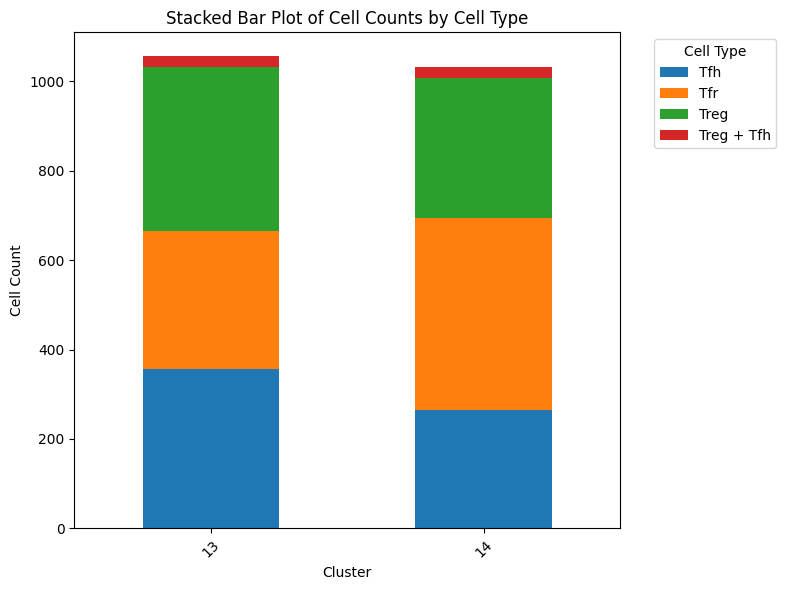

In [64]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_cc.groupby(["leiden_res_0.9", 'cell_type']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Cluster')
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [65]:
exp = adata.layers["data"].copy().transpose()
exp = exp[:, adata.obs["leiden_res_0.9"].isin(["14","13"])]
exp

<33262x2089 sparse matrix of type '<class 'numpy.float32'>'
	with 4280266 stored elements in Compressed Sparse Column format>

In [66]:
# make genes uniform
exp_cc = exp[g_use,:].transpose() # need to use the same g_use that was applied when training the classifier
exp_cc

<2089x17441 sparse matrix of type '<class 'numpy.float32'>'
	with 4279171 stored elements in Compressed Sparse Row format>

In [42]:
# Load the pre-fitted scaler
with open("analysis/model_classifier/new/v2_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [67]:
# Transform your data using the loaded scaler
exp_cc_sc = scaler.transform(exp_cc)

In [43]:
with open("analysis/model_classifier/new/v2_cal_rfc_model.pkl", "rb") as f:
    cal_rfc = pickle.load(f)

start_time = time.time()
pred_rfc = cal_rfc.predict(exp_class_sc)
print("RF 1vRest prediction time: %s seconds" % (round(time.time() - start_time, 2)))

with open("analysis/model_classifier/new/v2_cal_lr_model.pkl", "rb") as f:
    cal_lr = pickle.load(f)

start_time = time.time()
pred_lr = cal_lr.predict(exp_class_sc)
print("LR 1vRest prediction time: %s seconds" % (round(time.time() - start_time, 2)))

LR 1vRest prediction time: 11.03 seconds
LR 1vRest prediction time: 0.13 seconds


In [76]:
start_time = time.time()
pred_rfc = cal_rfc.predict(exp_cc_sc)
print("RF 1vRest prediction time: %s seconds" % (round(time.time() - start_time, 2)))

RF 1vRest prediction time: 11.8 seconds


In [75]:
start_time = time.time()
pred_lr = cal_lr.predict(exp_cc_sc)
print("LR 1vRest prediction time: %s seconds" % (round(time.time() - start_time, 2)))

LR 1vRest prediction time: 0.12 seconds


In [77]:
pred_lr.shape

(2089,)

In [78]:
sort = meta_cc.loc[meta_cc.index, 'cell_type']
sort.shape

(2089,)

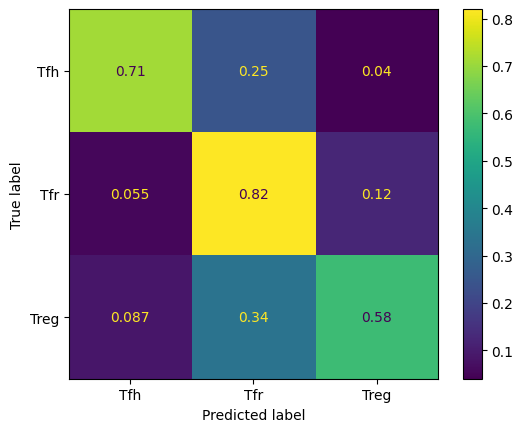

In [79]:
cm = confusion_matrix(sort, pred_lr, labels=cal_lr.classes_, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=cal_lr.classes_)
disp.plot()
plt.show()

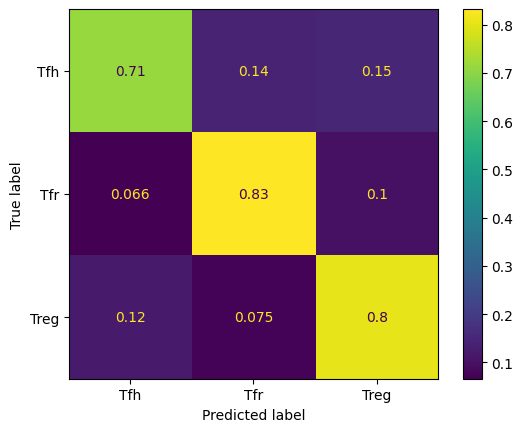

In [80]:
cm = confusion_matrix(sort, pred_rfc, labels=cal_lr.classes_, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=cal_lr.classes_)
disp.plot()
plt.show()

In [92]:
pd.crosstab(pred_lr, pred_rfc)

col_0,Tfh,Tfr,Treg
row_0,,,
Tfh,465,21,67
Tfr,87,690,240
Treg,34,46,439


In [81]:
pd.crosstab(sort, pred_rfc, normalize="index")

col_0,Tfh,Tfr,Treg
cell_type,,,
Tfh,0.713366,0.138486,0.148148
Tfr,0.066306,0.832206,0.101488
Treg,0.122239,0.075110,0.802651
Treg + Tfh,0.220000,0.100000,0.680000


In [82]:
pd.crosstab(sort, pred_rfc)

col_0,Tfh,Tfr,Treg
cell_type,,,
Tfh,443,86,92
Tfr,49,615,75
Treg,83,51,545
Treg + Tfh,11,5,34


In [85]:
ident = meta_cc.loc[meta_cc.index, 'orig.ident']
pd.crosstab(ident, pred_rfc)

col_0,Tfh,Tfr,Treg
orig.ident,,,
D104T11,439,9,400
D104T13,23,40,242
D104T14,70,84,24
D104T15,49,107,74
D104T16,5,2,5
hCD2_d0_Treg,0,7,0
hCD2_d6_Tfr,0,504,1
hCD2_d11_Tfr,0,4,0


In [86]:
sample = meta_cc.loc[meta_cc.index, 'sample_type']
pd.crosstab([sample, sort], pred_rfc)

col_0                        Tfh  Tfr  Treg
sample_type      cell_type                 
d0_Treg          Treg          5    9     5
d6_Mix(Treg+Tfh) Tfh         373    2    68
                 Treg         55    2   298
                 Treg + Tfh   11    5    34
d6_Tfr           Tfr           0  504     1
d11_Tfh          Tfh          70   84    24
d11_Tfr          Tfr          49  111    74
d11_Treg         Treg         23   40   242

In [93]:
sample = meta_cc.loc[meta_cc.index, 'sample_type']
pd.crosstab([sample, sort], pred_lr)

col_0                        Tfh  Tfr  Treg
sample_type      cell_type                 
d0_Treg          Treg          3    8     8
d6_Mix(Treg+Tfh) Tfh         367   65    11
                 Treg         45   64   246
                 Treg + Tfh   10   29    11
d6_Tfr           Tfr           0  471    34
d11_Tfh          Tfh          76   88    14
d11_Tfr          Tfr          41  135    58
d11_Treg         Treg         11  157   137

In [87]:
meta_cc["pred_lr"] = pred_lr
meta_cc["pred_rfc"] = pred_rfc

In [89]:
meta_cc.drop(columns=['annot_classifier'], inplace=True)

In [90]:
meta_cc

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.rb,experiment,day,cell_type,S.Score,G2M.Score,...,leiden_res_0.4,leiden_res_0.5,leiden_res_0.6,leiden_res_0.7,leiden_res_0.8,leiden_res_0.9,leiden_res_1.0,bbknn_annotation,pred_lr,pred_rfc
D104T11_AAACCTGGTAAGGATT-1,D104T11,1000,621,4.100000,16.700000,GFP,6,Treg + Tfh,-0.047334,0.387270,...,7,7,10,3,13,14,18,CellCycle,Treg,Treg
D104T11_AAACGGGGTGTGCGTC-1,D104T11,1350,789,3.481481,23.037037,GFP,6,Treg,-0.074114,0.069875,...,7,2,10,3,13,13,20,CellCycle,Treg,Treg
D104T11_AAACGGGGTGTGGCTC-1,D104T11,6375,2375,2.384314,19.435294,GFP,6,Treg,0.395656,0.689055,...,7,7,10,3,13,14,18,CellCycle,Treg,Treg
D104T11_AAAGCAAGTCAGTGGA-1,D104T11,1052,663,4.087452,15.114068,GFP,6,Treg + Tfh,0.118679,0.340995,...,7,7,10,3,13,14,18,CellCycle,Tfh,Treg
D104T11_AAATGCCCATGCCTAA-1,D104T11,6321,2139,1.044139,22.227496,GFP,6,Tfh,-0.040218,0.356588,...,7,7,10,3,13,13,20,CellCycle,Tfh,Tfh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hCD2_d6_Tfr_TTTGGTTCACCCAAGC-1,hCD2_d6_Tfr,29990,5071,2.140714,25.161721,hCD2,6,Tfr,0.443249,0.526781,...,7,7,10,3,13,13,20,CellCycle,Treg,Tfr
hCD2_d11_Tfr_CAACGATGTAGGTAGC-1,hCD2_d11_Tfr,2240,912,0.089286,32.767857,hCD2,11,Tfr,-0.076063,0.126199,...,7,7,10,3,13,13,20,CellCycle,Tfr,Tfr
hCD2_d11_Tfr_TCACTCGTCAACACCA-1,hCD2_d11_Tfr,10398,3225,3.616080,11.415657,hCD2,11,Tfr,0.442761,1.106394,...,7,7,10,3,13,14,18,CellCycle,Treg,Tfr
hCD2_d11_Tfr_TCGAAGTGTCGCATTA-1,hCD2_d11_Tfr,17833,3485,1.968261,30.297763,hCD2,11,Tfr,-0.090494,0.440915,...,7,7,10,3,13,13,20,CellCycle,Tfr,Tfr


In [94]:
meta_cc.to_csv("analysis/model_classifier/new/meta_cellcycle_predictions.csv", index=True)

In [3]:
meta_cc = pd.read_csv("analysis/model_classifier/new/meta_cellcycle_predictions.csv", index_col=0)

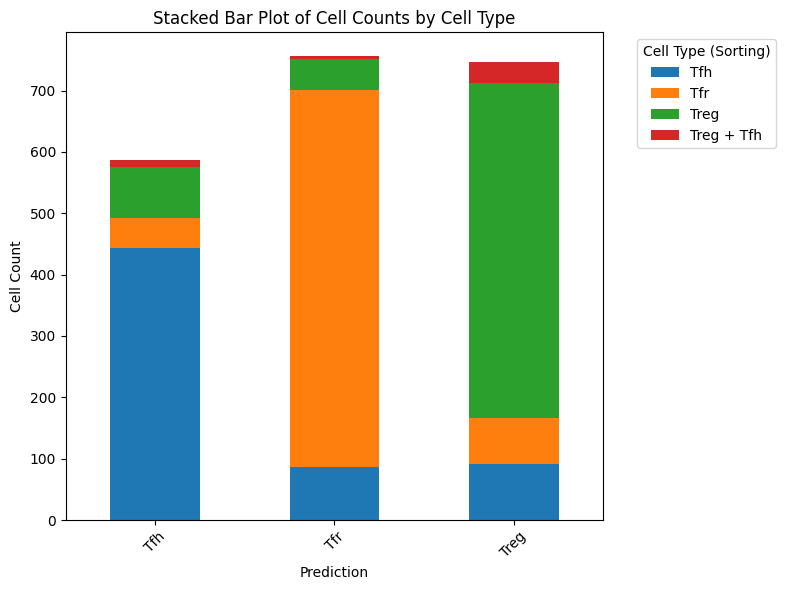

In [4]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_cc.groupby(["pred_rfc", 'cell_type']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Prediction')
plt.xticks(rotation=45)
plt.legend(title='Cell Type (Sorting)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

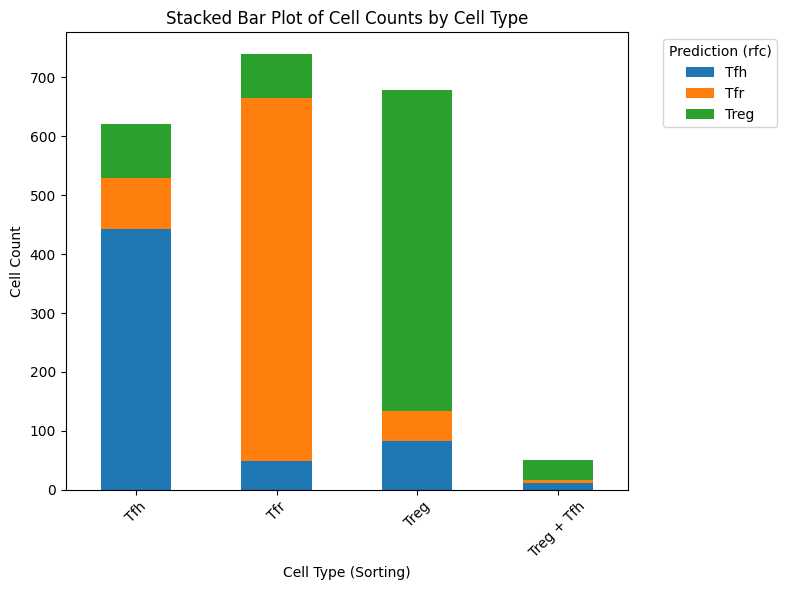

In [5]:
# Create a pivot table: rows = annot_classifier, columns = cell_type
pivot = meta_cc.groupby(["cell_type", 'pred_rfc']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Stacked Bar Plot of Cell Counts by Cell Type')
plt.ylabel('Cell Count')
plt.xlabel('Cell Type (Sorting)')
plt.xticks(rotation=45)
plt.legend(title='Prediction (rfc)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()